In [ ]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import random
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Ensure NLTK data is ready
nltk.download('stopwords', quiet=True)

True

### Import of dataset

In [2]:
USE_COLS = [
    "lyrics",
    "year",
    "language_cld3",
    "language_ft",
    "tag",
    "artist",
    "title",
    "views"
]

chunks = []
CHUNK_SIZE = 50_000  

for chunk in pd.read_csv(
    "song_lyrics_filtered.csv",
    usecols=USE_COLS,
    chunksize=CHUNK_SIZE,
    low_memory=True,
    engine="python"  
):
    # filter
    chunk = chunk[
        (chunk["language_cld3"] == "en") &
        (chunk["language_ft"] == "en") &
        (chunk["tag"] == "pop")
    ]
    
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
# Deleting irrelevant columns
df = df.drop(["language_cld3", "language_ft", "tag"], axis=1)
# Df check
print(df.shape)
df.head()

(1393559, 5)


,title,artist,year,views,lyrics
0,Wordy Rappinghood,Tom Tom Club,1981,26499,[Chorus]\nWhat are words worth?\nWhat are word...
1,Horchata,Vampire Weekend,2009,102550,"[Verse 1]\nIn December, drinking horchata\nI'd..."
2,Heartless,Kanye West,2008,1175109,"[Chorus]\nIn the night, I hear 'em talk\nThe c..."
3,Flashing Lights,Kanye West,2007,1078113,[Intro: Connie Mitchell]\nFlashing lights (Lig...
4,Baby,Justin Bieber,2010,2232442,[Produced by The-Dream and Tricky Stewart]\n\n...


In [3]:
# Saving df
df.to_parquet(
    "data/pop_lyrics.parquet",
    index=False
)

In [4]:
# Import df
df = pd.read_parquet("data/pop_lyrics.parquet")

### Descriptive statistics

In [5]:
print(df.info())
# No missing values 
# Dupes check in df
print(df[df.duplicated(subset=["title", "artist"], keep=False)] \
  .sort_values(["artist", "title"]))
# Removing dupes
df = df.drop_duplicates(subset=["title", "artist"], keep="first")
print(df.shape)

<class 'pandas.DataFrame'>
RangeIndex: 1393559 entries, 0 to 1393558
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   title   1393536 non-null  str  
 1   artist  1393559 non-null  str  
 2   year    1393559 non-null  int64
 3   views   1393559 non-null  int64
 4   lyrics  1393559 non-null  str  
dtypes: int64(2), str(3)
memory usage: 1.6 GB
None
                     title  artist  year  views  \
1175764  Celebrate Me Home    CAIN  2020    666   
1255799  Celebrate Me Home    CAIN  2020     32   
989544                 HOT  kenzie  2019  32727   
990182                 HOT  kenzie  2019   6911   

                                                    lyrics  
1175764  [Verse 1]\nHome for the holidays\nI believe I'...  
1255799  [Verse 1]\nHome for the holidays\nI believe I'...  
989544   [Verse 1]\nShould've listened to my friends\nT...  
990182   [Intro]\nWatch out\nWatch out\n\n[Verse 1]\nSh...  
(1393557, 5)


In [ ]:
# Descriptive statistics for numerics columns
print(df[["year", "views"]].describe())
print(df["year"].value_counts().sort_index())
# Incoherence in values for year (min and max)

               year         views
count  1.393557e+06  1.393557e+06
mean   2.008293e+03  2.399166e+03
std    2.937912e+01  4.296157e+04
min    1.000000e+00  0.000000e+00
25%    2.003000e+03  3.100000e+01
50%    2.014000e+03  1.070000e+02
75%    2.018000e+03  3.980000e+02
max    2.057000e+03  1.456973e+07
year
1          178
2            2
3            1
4            2
7            1
         ...  
2021    104796
2022     22709
2023       107
2024         9
2057         1
Name: count, Length: 254, dtype: int64


In [ ]:
# Filter to keep only years were there is more than 2000 songs
valid_years = df["year"].value_counts()
valid_years = valid_years[valid_years >= 2000].index
df = df[df["year"].isin(valid_years)]

print(df["year"].value_counts().sort_index().to_string())

year
1964      2176
1965      2705
1966      2768
1967      3208
1968      3494
1969      3367
1970      3190
1971      3110
1972      3223
1973      3029
1974      3014
1975      3454
1976      3318
1977      3514
1978      3698
1979      4024
1980      4334
1981      4632
1982      5163
1983      5177
1984      5231
1985      5734
1986      5926
1987      6487
1988      6899
1989      7603
1990      8010
1991      8989
1992      9408
1993     10983
1994     12267
1995     14063
1996     15394
1997     17075
1998     17835
1999     20887
2000     21616
2001     23244
2002     25085
2003     27230
2004     29016
2005     30027
2006     32319
2007     30836
2008     32091
2009     31537
2010     31093
2011     33306
2012     33253
2013     33622
2014     28634
2015    203396
2016     38003
2017     49531
2018     73186
2019     89177
2020    110099
2021    104796
2022     22709


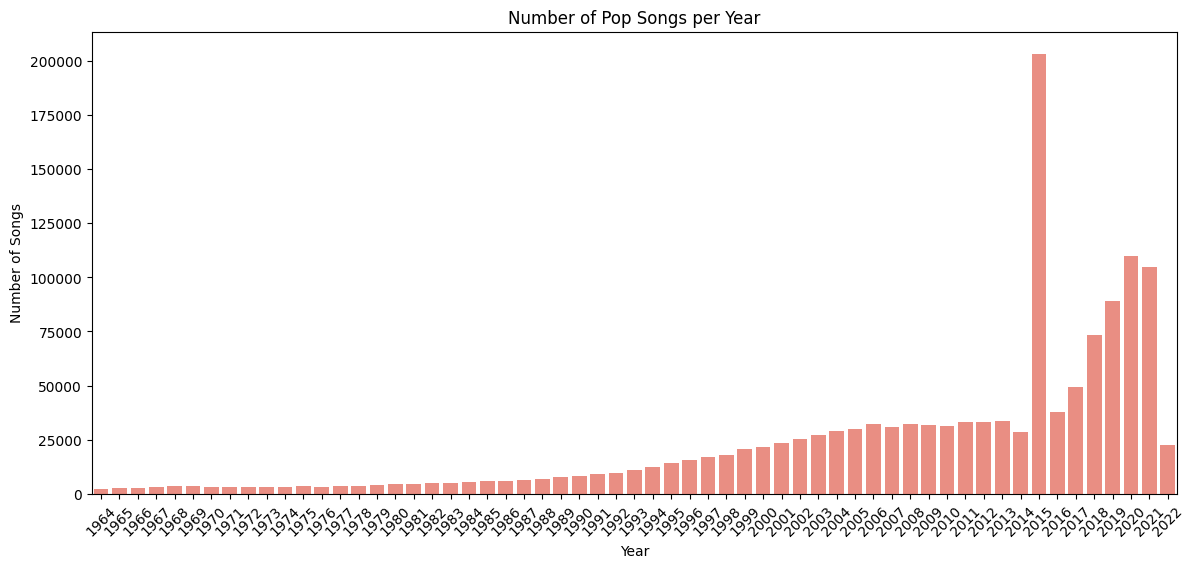

In [13]:
# Visualisation of songs per year
songs_per_year = df["year"].value_counts().sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, color="salmon")
plt.title("Number of Pop Songs per Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Top 10 artists in the df
df["artist"].value_counts().head(10)
# Genius English Translations needs to be removed (the originals songs are not in English)

artist
Genius English Translations    8158
KIDZ BOP Kids                  1181
Madonna                         949
YOUNG DIAMOND                   833
Glee Cast                       706
Frank Sinatra                   624
Pet Shop Boys                   611
Erasure                         590
The Beach Boys                  581
Depeche Mode                    569
Name: count, dtype: int64

In [ ]:
# Removing Genius translations
mask_artist = ~df["artist"].str.contains(
    "Genius|Translation|Translations",
    case=False,
    na=False
)

# Filter
df = df[mask_artist 
        ]

C:\Users\isali\AppData\Local\Temp\ipykernel_32068\2963463325.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


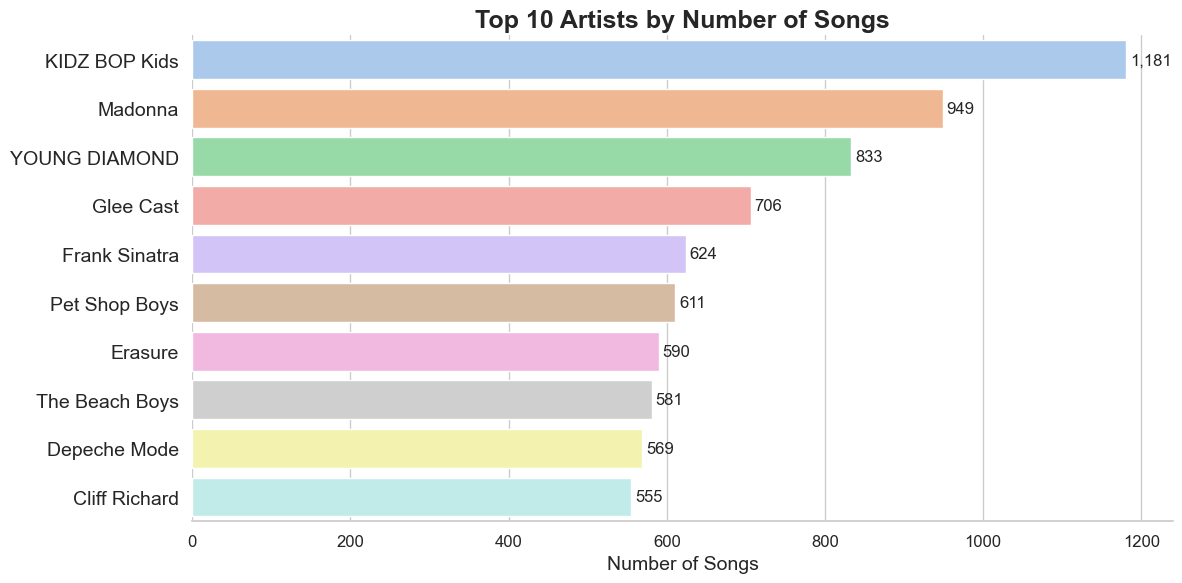

In [ ]:
# Visualisation of top artists
top_artists = df["artist"].value_counts().head(10).reset_index()
top_artists.columns = ["artist", "count"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))
palette = sns.color_palette("pastel", n_colors=len(top_artists))

ax = sns.barplot(
    data=top_artists,
    x="count",
    y="artist",
    palette=palette
)

for i, v in enumerate(top_artists["count"]):
    ax.text(v + 5, i, f"{v:,}", va="center", fontsize=12)
ax.set_title("Top 10 Artists by Number of Songs", fontsize=18, weight="bold")
ax.set_xlabel("Number of Songs", fontsize=14)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=12)
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [23]:
# Quick check of the title and count coherence
df[df["artist"] == "Madonna"]["title"].value_counts().head(20)

title
4 Minutes                           1
Beat Goes On                        1
Like a Virgin / Hollywood Medley    1
Give Me All Your Luvin              1
I Dont Give A                       1
Girl Gone Wild                      1
Love Spent                          1
Im Addicted                         1
Die Another Day                     1
Like a Virgin                       1
Beautiful Stranger                  1
Dress You Up                        1
Vogue                               1
Superstar                           1
Express Yourself                    1
Like a Prayer                       1
Gang Bang                           1
Falling Free                        1
Music                               1
Material Girl                       1
Name: count, dtype: int64

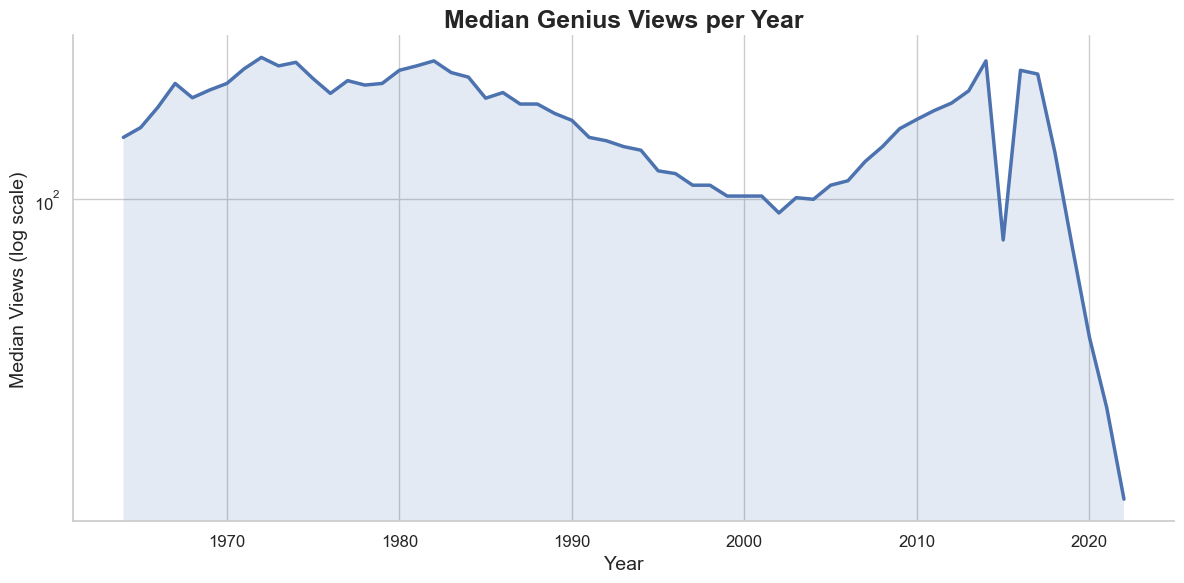

In [26]:
# Visualisation of views evolution
views_by_year = (
    df.groupby("year")["views"]
    .median()
    .reset_index()
)

plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=views_by_year,
    x="year",
    y="views",
    linewidth=2.5
)

ax.fill_between(
    views_by_year["year"],
    views_by_year["views"],
    alpha=0.15
)

ax.set_yscale("log")

ax.set_title("Median Genius Views per Year", fontsize=18, weight="bold")
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Median Views (log scale)", fontsize=14)

ax.tick_params(axis='both', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


### Cleaning of the lyrics

In [ ]:
# Creation of a stopwords list for lyrics
music_stopwords = [
    'like', 'thing', 'things', 'bit', 'little', 'let', 'lets',
    # Vocal fillers / ad-libs
    'yeah', 'yea', 'yah', 'ya',
    'la', 'na', 'nah',
    'oh', 'ooh', 'oooh', 'uh', 'uhh', 'huh', 'hmm',
    'hey', 'yo', 'aye', 'ayy',
    'da', 'di', 'dum', 'doo',

    # Generic pop references
    'baby', 'babe', 'girl', 'boy',
    'man', 'woman',
    'girls', 'boys',

    # Spoken / conversational fillers
    'well', 'right', 'okay', 'ok',
    'alright', 'alrighty',
    'really', 'just', 'still',
    'every', 'everything', 'something', 'nothing',

    # Common verbs (low semantic value in lyrics)
    'got', 'get', 'getting',
    'go', 'going', 'gone',
    'come', 'coming',
    'make', 'made',
    'see', 'seen',
    'say', 'said',
    'take', 'taken',
    'give', 'given',
    'keep', 'kept',
    'look', 'looking',
    'think', 'thinking',
    'tell', 'told',
    'know', 'knew',
    'feel', 'feeling',
    'want', 'wanted',
    'need', 'needed',
    'try', 'trying',

    # Time / quantity fillers
    'one', 'two', 'time', 'times',
    'day', 'night',
    'forever', 'never', 'ever',
    'always', 'sometimes',

    # Movement / direction
    'away', 'back', 'around',
    'down', 'up', 'out', 'in',

    # Modal / auxiliary verbs
    'would', 'could', 'should',
    'can', 'cant', 'cannot',
    'will', 'wont', 'dont', 'didnt',
    'im', 'ive', 'ill', 'youre', 'youve', 'youll',
    'weve', 'were', 'theyre',

    # Slang / contractions
    'wanna', 'gonna', 'gon',
    'ain', 'cause', 'cuz',
    'lemme', 'gimme',

    # Song-structure words
    'chorus', 'verse', 'hook',
    'repeat', 'bridge',

    # Generic emotional words (remove to have emotion topics)
    #'love', 'heart',
    'feelin', 'feels',
    #'dream', 'light', 'sky', 'star', 'shine', 'wings', 'soul'

]


In [30]:
#STOPWORDS = set(stopwords.words("english"))
# Expand stop words with generic music filler/generic verbs
STOPWORDS = list(nltk.corpus.stopwords.words('english')) + music_stopwords
def clean_lyrics(text):
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower()
    tokens = [
        w for w in text.split()
        if w not in STOPWORDS and len(w) > 2
    ]
    return " ".join(tokens)

df["clean_lyrics"] = df["lyrics"].astype(str).apply(clean_lyrics)

# View of clean lyrics
print(df["clean_lyrics"].head())
print(df["clean_lyrics"].loc[1])

0    words worth words worth words words papers wor...
1    december drinking horchata psychotic balaclava...
2    hear talk coldest story somewhere far along ro...
3    flashing lights lights lights flashing lights ...
4    woah woah woah care shout whenever apart item ...
Name: clean_lyrics, dtype: str
december drinking horchata psychotic balaclava winter cold much handle pincher crabs pinch sandals december drinking horchata glasses aranciata lips teeth ask went boots fists pound pavement comes thought forgotten chairs sit sidewalks walk remember drinking horchata enjoy foot masada winter cold much handle pincher crabs pinch sandals comes thought forgotten chairs sit sidewalks walk lost fought december drinking horchata psychotic balaclava winter cold much handle pincher crabs pinch sandals years hearts start harden palms firs grew garden falling nearing rosebeds roots shooting tool shed lips teeth asked went shouting cracks pavement comes thought forgotten chairs sit sidewalks walk

In [31]:
# Saving clean lyrics df
df.to_parquet(
    "data/pop_lyrics_nlp_clean.parquet",
    index=False
)

In [24]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/pop_lyrics_nlp_clean.parquet"
)

### Database Creation

In [32]:
# --- DECOUPLING SELECTION LOGIC AND DATABASE CREATION ---
# This cell creates the 'df_analysis' dataframe which serves as our final database for LDA.

# 1. Configuration
MAX_PER_YEAR = 1000  
START_YEAR = 1964
END_YEAR = 2022

# 2. Filter dataset
df_filtered = df.query("year >= @START_YEAR and year <= @END_YEAR")

# 3. Create 'Top' songs subset (most viewed)
df_top = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, False])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
).copy()
df_top["popularity"] = "top"

# 4. Create 'Flop' songs subset (least viewed)
df_flop = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, True])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
).copy()
df_flop["popularity"] = "flop"

# 5. Build Final Analysis Database
df_analysis = pd.concat([df_top, df_flop], ignore_index=True)
df_analysis["is_top"] = (df_analysis["popularity"] == "top").astype(int)

# 6. Safety Check
print(f"Database 'df_analysis' created successfully.")
print(f"Total documents: {len(df_analysis)}")
print(f"Popularity Breakdown:\n{df_analysis['popularity'].value_counts()}")
print("\nSample Data (titles):")
print(df_analysis[["title", "artist", "year", "popularity"]].head())

Database 'df_analysis' created successfully.
Total documents: 118000
Popularity Breakdown:
popularity
top     59000
flop    59000
Name: count, dtype: int64

Sample Data (titles):
                                title         artist  year popularity
0                  Fly Me to the Moon  Frank Sinatra  1964        top
1                            Downtown   Petula Clark  1964        top
2            The Way You Look Tonight  Frank Sinatra  1964        top
3  Supercalifragilisticexpialidocious  Julie Andrews  1964        top
4          Put on Your Sunday Clothes   Jerry Herman  1964        top


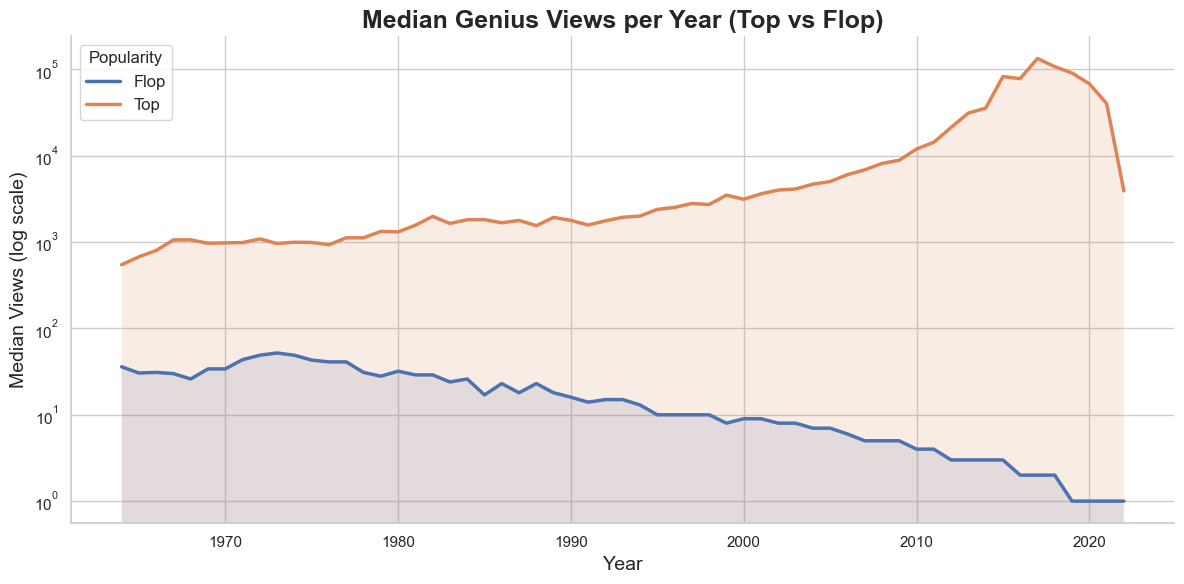

In [ ]:
# Visualisation of median views by year
sns.set_theme(style="whitegrid")
views_by_year = (
    df_analysis.groupby(["year", "popularity"])["views"]
    .median()
    .reset_index()
)

plt.figure(figsize=(12,6))
for pop in views_by_year["popularity"].unique():
    subset = views_by_year[views_by_year["popularity"] == pop]
    plt.plot(subset["year"], subset["views"], linewidth=2.5, label=pop.capitalize())
    plt.fill_between(subset["year"], subset["views"], alpha=0.15)

plt.yscale("log")
plt.title("Median Genius Views per Year (Top vs Flop)", fontsize=18, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Median Views (log scale)", fontsize=14)
plt.legend(title="Popularity", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


C:\Users\isali\AppData\Local\Temp\ipykernel_32068\345452845.py:25: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  ax = sns.barplot(


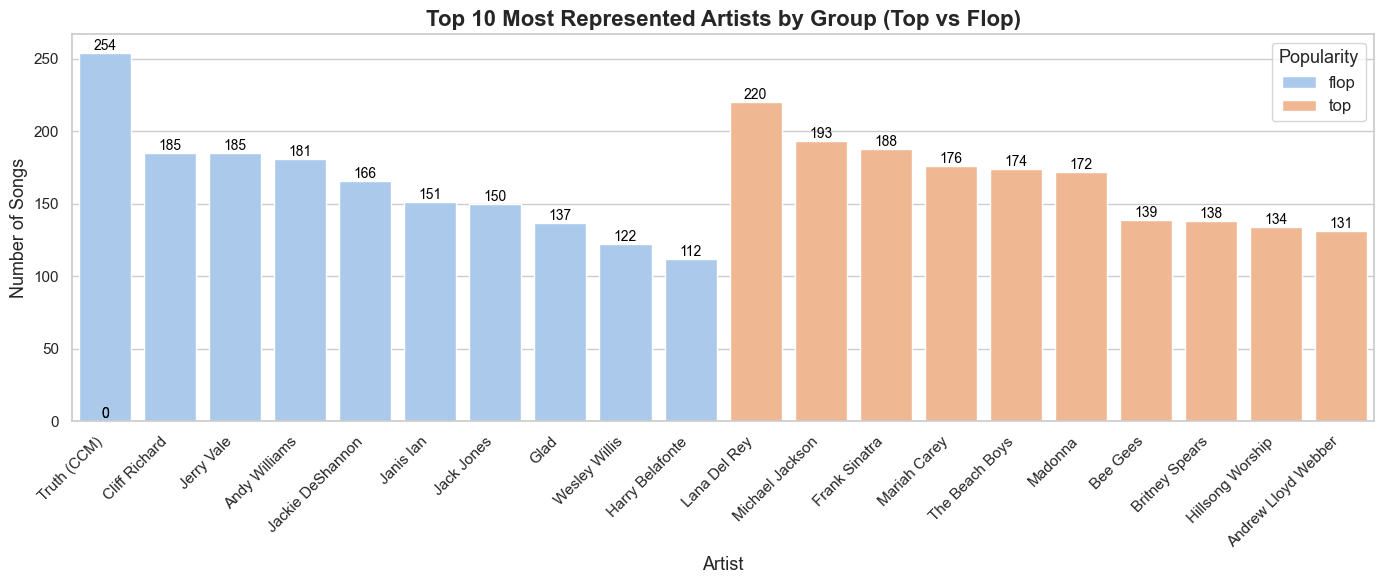

In [ ]:
# Visualisation of top artists - top and flop
sns.set_theme(style="whitegrid")

# Compute top artists by group 
top_artists_by_group = (
    df_analysis
    .groupby(["popularity", "artist"])
    .size()
    .reset_index(name="n_songs")
)

# Keep top 10 artists per group
top_artists_by_group = (
    top_artists_by_group
    .sort_values(["popularity", "n_songs"], ascending=[True, False])
    .groupby("popularity")
    .head(10)
)

plt.figure(figsize=(14,6))
palette = sns.color_palette("pastel", n_colors=len(top_artists_by_group["artist"].unique()))

ax = sns.barplot(
    data=top_artists_by_group,
    x="artist",
    y="n_songs",
    hue="popularity",
    palette=palette
)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom", fontsize=10, color="black")

plt.title("Top 10 Most Represented Artists by Group (Top vs Flop)", fontsize=16, weight="bold")
plt.ylabel("Number of Songs", fontsize=13)
plt.xlabel("Artist", fontsize=13)
plt.xticks(rotation=45, ha="right", fontsize=11)

plt.legend(title="Popularity", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

In [36]:
# --- FULL NLP FEATURE ENGINEERING (Sentiment, Emotion, Readability, structural) ---

# 1. Initialize Sentiment (VADER)
analyzer = SentimentIntensityAnalyzer()

# 2. Load Emotion Lexicon (NRC)
nrc_path = "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc_dict = defaultdict(list)
if os.path.exists(nrc_path):
    nrc_data = pd.read_csv(nrc_path, sep="\t", names=["word", "emotion", "association"])
    nrc_data = nrc_data[nrc_data["association"] == 1]
    for _, row in nrc_data.iterrows():
        nrc_dict[row["word"]].append(row["emotion"])
    print(f"✓ Loaded {len(nrc_dict)} words from NRC Lexicon.")
else:
    print("⚠ NRC Lexicon file not found. Emotion scores will be skipped.")

def get_nrc_scores(text):
    tokens = str(text).lower().split()
    counts = Counter()
    for t in tokens:
        for em in nrc_dict.get(t, []):
            counts[em] += 1
    total = sum(counts.values())
    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust", "positive", "negative"]
    if total == 0: return {e: 0 for e in emotions}
    return {e: counts[e]/total for e in emotions}

# 3. Calculate All Metrics
print("Engineering NLP features (this may take a minute)...")

# Sentiment
vader_scores = df_analysis['clean_lyrics'].apply(lambda x: analyzer.polarity_scores(str(x)))
df_analysis['sentiment_compound'] = vader_scores.apply(lambda x: x['compound'])
df_analysis['sentiment_pos'] = vader_scores.apply(lambda x: x['pos'])
df_analysis['sentiment_neg'] = vader_scores.apply(lambda x: x['neg'])
df_analysis['sentiment_neu'] = vader_scores.apply(lambda x: x['neu'])

# Emotion
nrc_scores = df_analysis['clean_lyrics'].apply(get_nrc_scores)
df_emotions = pd.json_normalize(nrc_scores)
df_analysis = pd.concat([df_analysis, df_emotions], axis=1)

# Readability
df_analysis['flesch_reading_ease'] = df_analysis['clean_lyrics'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
df_analysis['flesch_kincaid_grade'] = df_analysis['clean_lyrics'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))

# Structural
df_analysis['word_count'] = df_analysis['clean_lyrics'].str.split().str.len()
df_analysis['lexical_diversity'] = df_analysis['clean_lyrics'].apply(
    lambda x: len(set(str(x).split())) / len(str(x).split()) if len(str(x).split()) > 0 else 0
)

print(f"✓ Feature engineering complete for {len(df_analysis)} songs.")
print(f"Included features: Sentiment (4), Emotions (10), Readability (2), Structural (3)")

✓ Loaded 6453 words from NRC Lexicon.
Engineering NLP features (this may take a minute)...
✓ Feature engineering complete for 118000 songs.
Included features: Sentiment (4), Emotions (10), Readability (2), Structural (3)


In [37]:
import re

def collapse_repetitions(text):
    if not isinstance(text, str):
        return text
    # Collapse immediate repetitions (e.g., "work work work" -> "work")
    # Matches a word (\b\w+\b) followed by one or more occurrences of the same word
    return re.sub(r'\b(\w+)(?:\s+\1\b)+', r'\1', text, flags=re.IGNORECASE)

print("Collapsing immediate repetitions in lyrics (e.g., 'yeah yeah' -> 'yeah')...")
df_analysis['clean_lyrics'] = df_analysis['clean_lyrics'].apply(collapse_repetitions)

Collapsing immediate repetitions in lyrics (e.g., 'yeah yeah' -> 'yeah')...


In [38]:
df.to_parquet(
    "data/pop_lyrics_to_model.parquet",
    index=False
)

In [28]:
df = pd.read_parquet(
    "data/pop_lyrics_to_model.parquet"
)

## Sentiment Analysis - Visualisation

### Vader

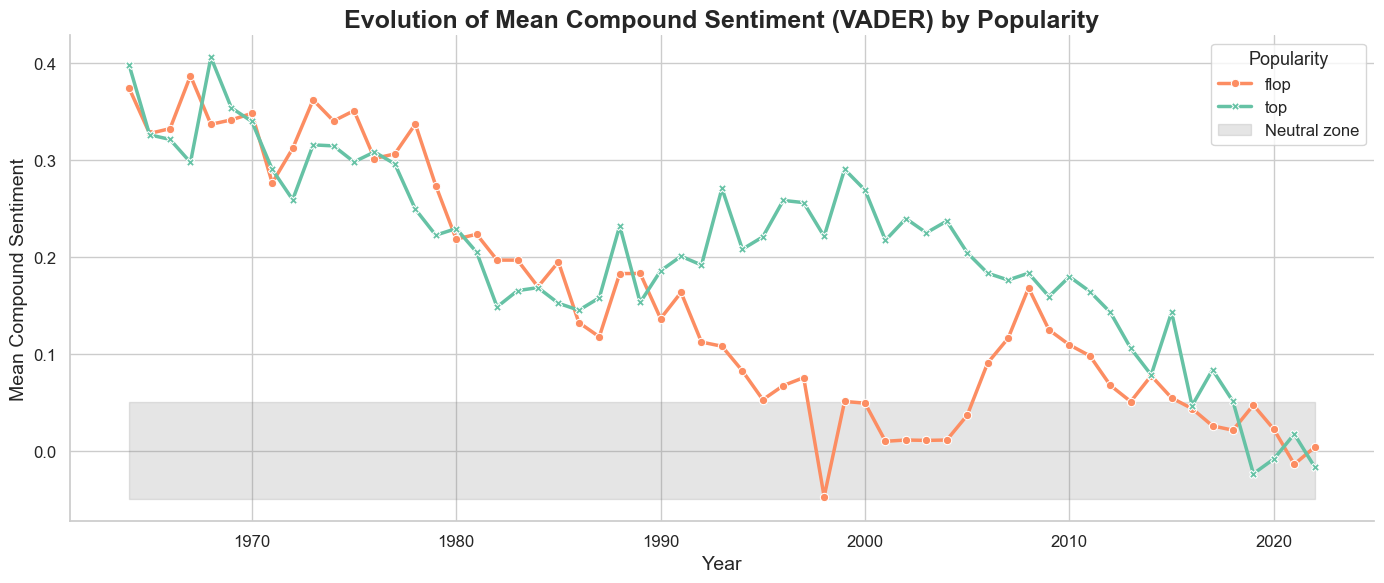

In [ ]:
# Visualisation of Vader sentiment compound - top and flop
sns.set_theme(style="whitegrid")

# Compute mean compound sentiment per year per group
sentiment_by_year = (
    df_analysis
    .groupby(["year", "popularity"])["sentiment_compound"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(14,6))
ax = sns.lineplot(
    data=sentiment_by_year,
    x="year",
    y="sentiment_compound",
    hue="popularity",
    style="popularity",
    markers=True,
    dashes=False,
    linewidth=2.5,
    palette={"top":"#66c2a5", "flop":"#fc8d62"}  
)
ax.fill_between(sentiment_by_year["year"], -0.05, 0.05, color="gray", alpha=0.2, label="Neutral zone")
ax.set_title("Evolution of Mean Compound Sentiment (VADER) by Popularity", fontsize=18, weight="bold")
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Mean Compound Sentiment", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
plt.legend(title="Popularity", fontsize=12, title_fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()

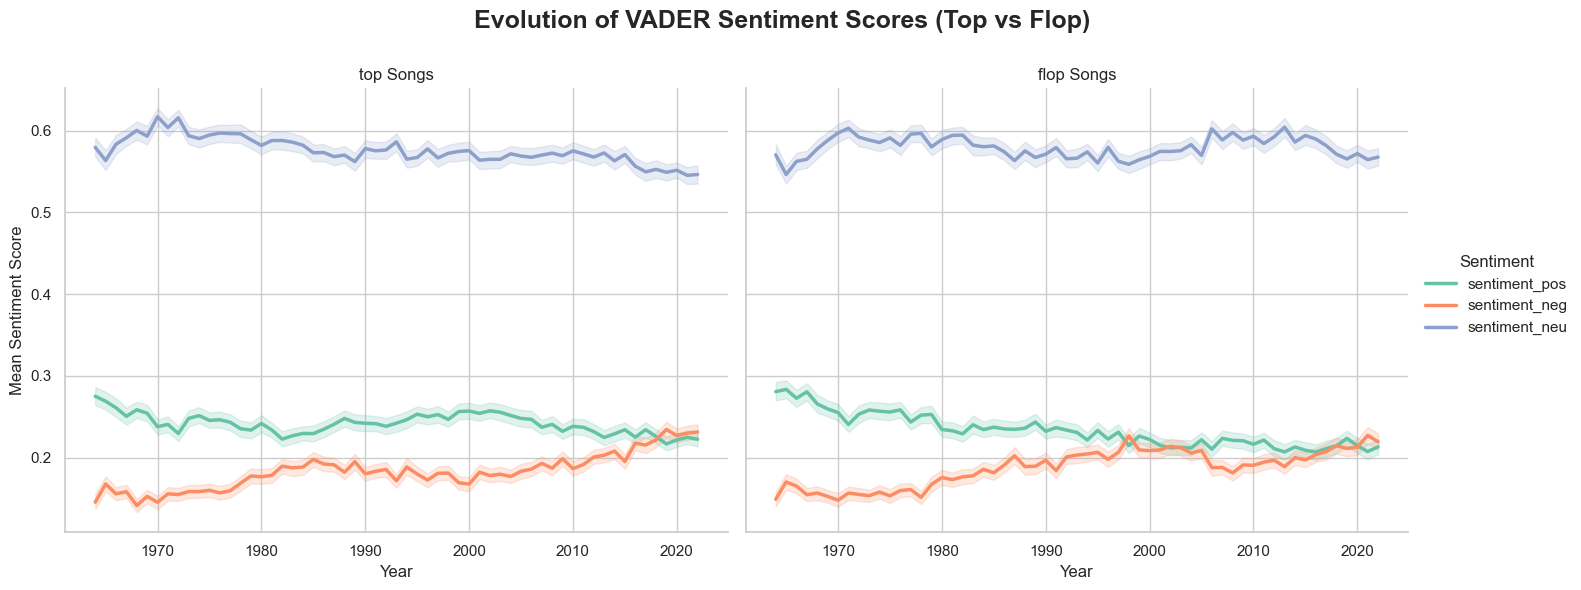

In [42]:
# Vader visualisation for other sentiments
sentiments = ["sentiment_pos", "sentiment_neg", "sentiment_neu"]

df_melted = df_analysis.melt(
    id_vars=["year", "popularity"],
    value_vars=sentiments,
    var_name="sentiment_type",
    value_name="score"
)

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(
    df_melted, 
    col="popularity", 
    height=6, 
    aspect=1.2, 
    sharey=True
)

g.map_dataframe(
    sns.lineplot, 
    x="year", 
    y="score", 
    hue="sentiment_type",
    palette={"sentiment_pos":"#66c2a5", "sentiment_neg":"#fc8d62", "sentiment_neu":"#8da0cb"},
    linewidth=2.5,
)

g.set_axis_labels("Year", "Mean Sentiment Score")
g.set_titles("{col_name} Songs")
g.add_legend(title="Sentiment")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Evolution of VADER Sentiment Scores (Top vs Flop)", fontsize=18, weight="bold")
plt.show()

### NRC

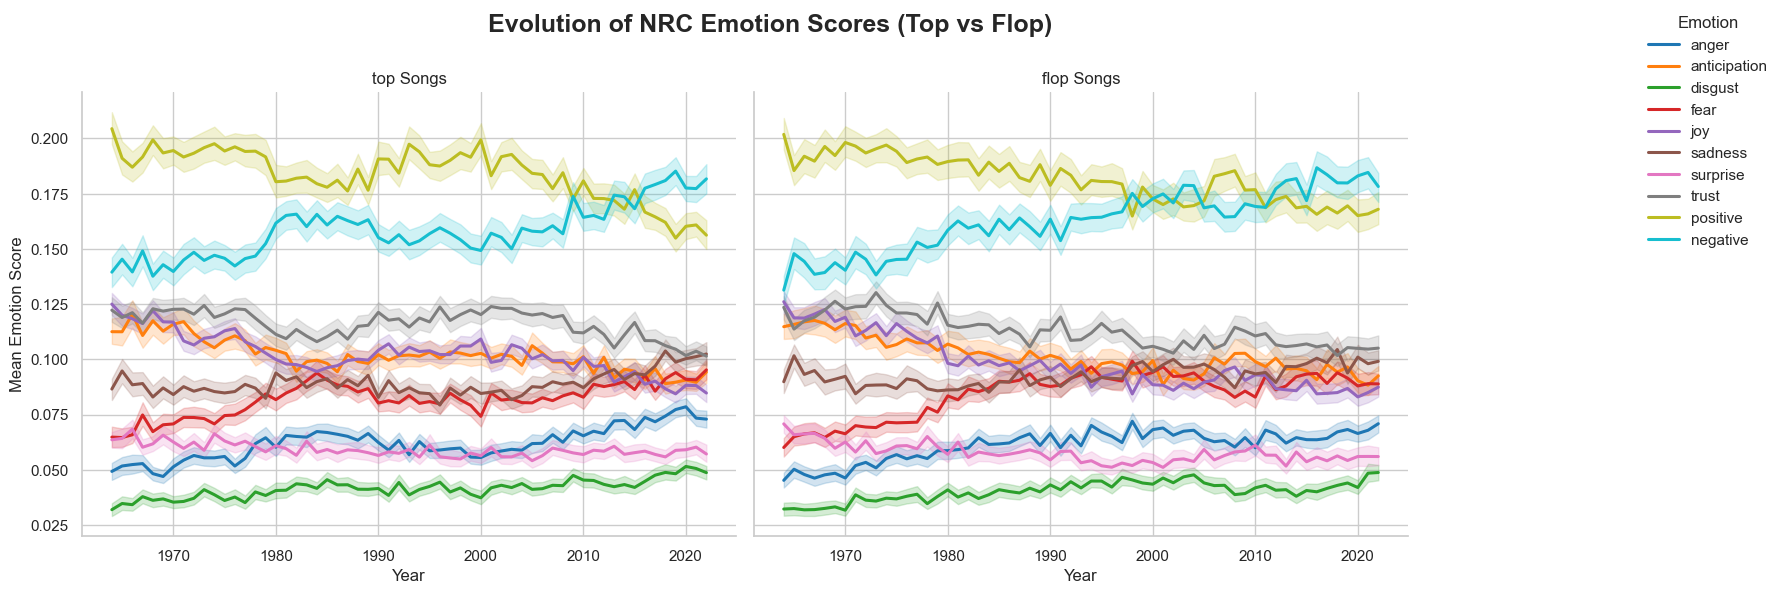

In [46]:
# Mean per year - top songs
nrc_emotions = ["anger", "anticipation", "disgust", "fear", 
                "joy", "sadness", "surprise", "trust", "positive", "negative"]

df_nrc_melted = df_analysis.melt(
    id_vars=["year", "popularity"],
    value_vars=nrc_emotions,
    var_name="emotion",
    value_name="score"
)

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(
    df_nrc_melted, 
    col="popularity", 
    height=6, 
    aspect=1.2, 
    sharey=True
)

palette = sns.color_palette("tab10", n_colors=len(nrc_emotions))

g.map_dataframe(
    sns.lineplot,
    x="year",
    y="score",
    hue="emotion",
    palette=palette,
    linewidth=2.2
)

g.set_axis_labels("Year", "Mean Emotion Score")
g.set_titles("{col_name} Songs")
g.add_legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Evolution of NRC Emotion Scores (Top vs Flop)", fontsize=18, weight="bold")
plt.show()

## Flesch Kincaid results

<Figure size 1400x600 with 0 Axes>

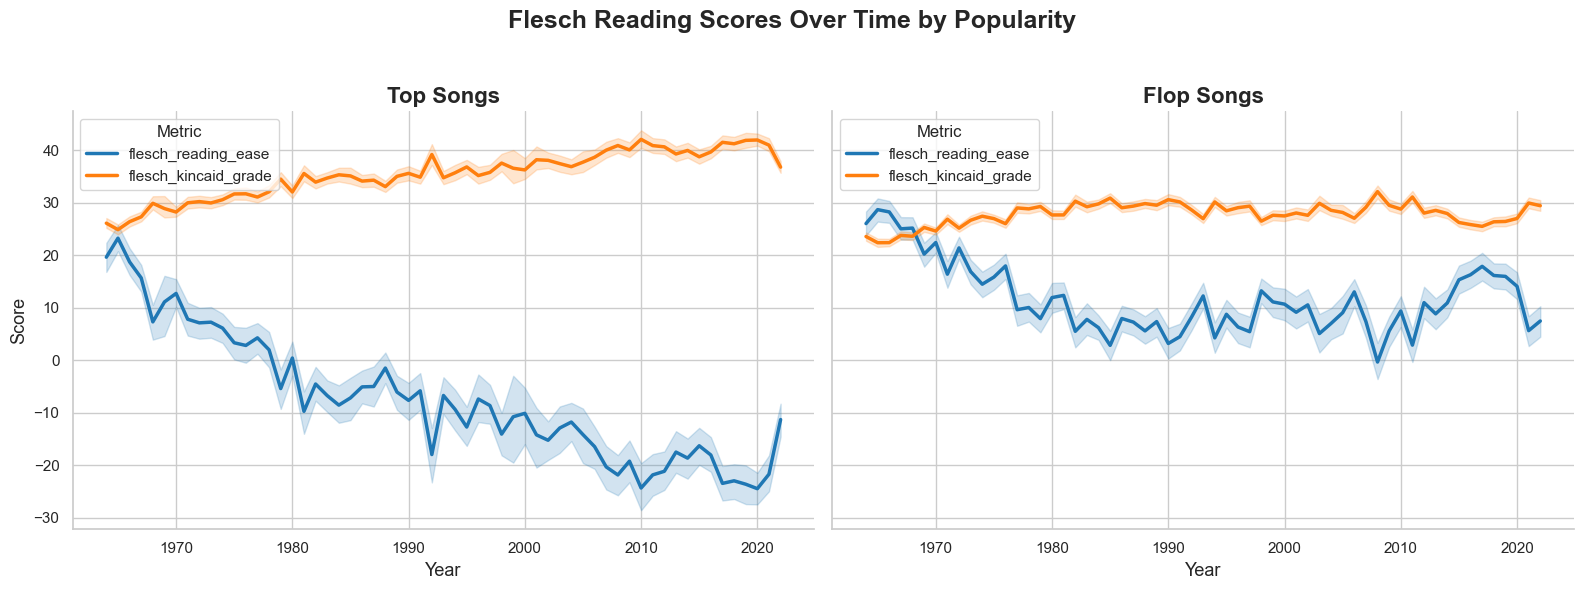

In [49]:
df_fk_melted = df_analysis.melt(
    id_vars=["year", "popularity"],
    value_vars=["flesch_reading_ease", "flesch_kincaid_grade"],
    var_name="metric",
    value_name="score"
)

plt.figure(figsize=(14,6))
sns.set_theme(style="whitegrid")

metrics = ["flesch_reading_ease", "flesch_kincaid_grade"]
palette = {"flesch_reading_ease": "#1f77b4", "flesch_kincaid_grade": "#ff7f0e"}

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

for ax, pop in zip(axes, ["top", "flop"]):
    subset = df_fk_melted[df_fk_melted["popularity"] == pop]
    sns.lineplot(
        data=subset,
        x="year",
        y="score",
        hue="metric",
        markers=True,
        dashes=False,
        palette=palette,
        linewidth=2.5,
        ax=ax
    )
    ax.set_title(f"{pop.capitalize()} Songs", fontsize=16, weight="bold")
    ax.set_xlabel("Year", fontsize=13)
    ax.set_ylabel("Score" if ax==axes[0] else "", fontsize=13)
    ax.tick_params(axis='both', labelsize=11)
    ax.legend(title="Metric", fontsize=11, title_fontsize=12, loc="upper left")

plt.suptitle("Flesch Reading Scores Over Time by Popularity", fontsize=18, weight="bold")
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## LDA

In [51]:
# Advanced CountVectorizer for Lyrics
# 1. Expand stop words with generic music filler/generic verbs
#custom_stopwords = list(nltk.corpus.stopwords.words('english')) + music_stopwords
# 2. Advanced configuration
cv = CountVectorizer(
    max_df=0.4,           # More strict: ignore words in >70% of songs (generic pop vocabulary)
    min_df=2,            # Ignore words appearing in <10 songs to reduce noise
    #stop_words=custom_stopwords,
    ngram_range=(1, 2),   # Capture Bigrams (e.g., "heart break", "stay together")
    max_features=10000    # Focus on the 10k most meaningful terms/phrases
)

print(f"Advanced CountVectorizer configured:")
print(f"  - Vocabulary size limit: {cv.max_features}")
print(f"  - N-gram range: {cv.ngram_range}")
#print(f"  - Custom stopwords added: {len(music_stopwords)} music-specific terms")

Advanced CountVectorizer configured:
  - Vocabulary size limit: 10000
  - N-gram range: (1, 2)


### LDA on combined dataset

In [52]:
# Construction of Document-Term matrix - all songs
dtm = cv.fit_transform(df_analysis['clean_lyrics'])

print(f"Document-Term matrix created")
print(f"  - Forme: {dtm.shape} (documents x vocabulary)")
print(f"  - {dtm.shape[0]} documents")
print(f"  - {dtm.shape[1]} words in the vocabulary")
print(f"  - Type: {type(dtm)}")

Document-Term matrix created
  - Forme: (118000, 10000) (documents x vocabulary)
  - 118000 documents
  - 10000 words in the vocabulary
  - Type: <class 'scipy.sparse._csr.csr_matrix'>


In [53]:
# LDA Concentration Tuning
# To reduce dispersion and increase concentration:
# 1. Lower doc_topic_prior (Alpha) -> Forces each document to pick fewer topics.
# 2. Lower topic_word_prior (Beta) -> Forces each topic to focus on fewer, more specific words.
# 3. Increase max_iter -> Allows the model to converge more strictly.

LDA = LatentDirichletAllocation(
    n_components=14,          # Reduced from 12 for stronger thematic clusters
    learning_offset=50.,
    random_state=42,
    learning_method="batch",
    max_iter=50,
    evaluate_every=1,
    doc_topic_prior=0.1,     # Extreme sparsity: each song will be strongly tied to 1-2 topics
    topic_word_prior=0.01,    # Extreme sparsity: makes words in topics more distinct
    n_jobs=-1
)

print(f"Model configured for high concentration:")
print(f"  - Topics: {LDA.n_components}")
print(f"  - Max iterations: {LDA.max_iter}")
print(f"  - Sparsity priors (Alpha/Beta): {LDA.doc_topic_prior} / {LDA.topic_word_prior}")

Model configured for high concentration:
  - Topics: 14
  - Max iterations: 50
  - Sparsity priors (Alpha/Beta): 0.1 / 0.01


In [ ]:
# Global LDA training
print("LDA training of full dataset...")
# LDA.fit handles the fitting, and returns itself.
LDA.fit(dtm)
print("✓ Training completed !")

# Assign topics to documents
print("Computing topic probabilities for each song...")
topic_results = LDA.transform(dtm)
df_analysis['Topic'] = topic_results.argmax(axis=1)

print("Topics distribution in full dataset :")
print(df_analysis['Topic'].value_counts().sort_index())

LDA training of full dataset...


In [ ]:
# Extraction of the first topic
single_topic = LDA.components_[0]
print(f"Topic 0 - Distribution on {len(single_topic)} words")

Topic 0 - Distribution sur 10000 mots


In [15]:
top_ten_words = single_topic.argsort()[-20:]

In [ ]:
# Index to words
print("\nTop 10 words for Topic 0:")
for index in top_ten_words:
    word = cv.get_feature_names_out()[index]
    prob = single_topic[index]
    print(f"  - {word:<20} (probability: {prob:.4f})")


Top 10 mots du Topic 0:
  - trust                (probabilité: 2372.2558)
  - word                 (probabilité: 2530.6181)
  - mean                 (probabilité: 2789.0984)
  - find way             (probabilité: 2805.0100)
  - understand           (probabilité: 3300.5771)
  - words                (probabilité: 3353.4278)
  - hand                 (probabilité: 3546.9827)
  - show                 (probabilité: 3631.1030)
  - set                  (probabilité: 3690.9153)
  - way way              (probabilité: 3789.0100)
  - anything             (probabilité: 4506.7459)
  - friend               (probabilité: 4583.5324)
  - find                 (probabilité: 5160.9057)
  - waiting              (probabilité: 5265.8675)
  - care                 (probabilité: 5556.6406)
  - help                 (probabilité: 6049.0566)
  - walk                 (probabilité: 6340.8337)
  - yes                  (probabilité: 7590.7404)
  - free                 (probabilité: 8383.9996)
  - way                  

In [ ]:
# On every topics
print("=" * 70)
print("TOPICS DISCOVERED BY LDA")
print("=" * 70)

for i, topic in enumerate(LDA.components_):
    print(f"\nTOPIC #{i}")
    print("-" * 70)
    top_words = [cv.get_feature_names_out()[idx] for idx in topic.argsort()[-40:]]
    print("Top 40 mots:", ', '.join(top_words))

print("\n" + "=" * 70)

TOPICS DÉCOUVERTS PAR LDA

TOPIC #0
----------------------------------------------------------------------
Top 40 mots: lead, please, forget, used, thank, easy, yes yes, much, talk, talking, speak, cool, low, believe, pray, ask, set free, might, gotta, anymore, trust, word, mean, find way, understand, words, hand, show, set, way way, anything, friend, find, waiting, care, help, walk, yes, free, way

TOPIC #1
----------------------------------------------------------------------
Top 40 mots: nobody knows, wah, name name, jesus jesus, nobody else, bounce, watch, weh, gal, dat, nobody nobody, runnin, shot, shoot, shame, wow, call, mmm mmm, breathe, work work, ooo, pon, gun, gyal, nuh, shake shake, inna, round round, jah, yuh, mmm, lady, run run, name, shake, work, dem, round, nobody, run

TOPIC #2
----------------------------------------------------------------------
Top 40 mots: six, blow, thought, party party, smile, hand, hold hand, holy holy, boom boom, seven, arms, comin, ready ready

<Figure size 1400x600 with 0 Axes>

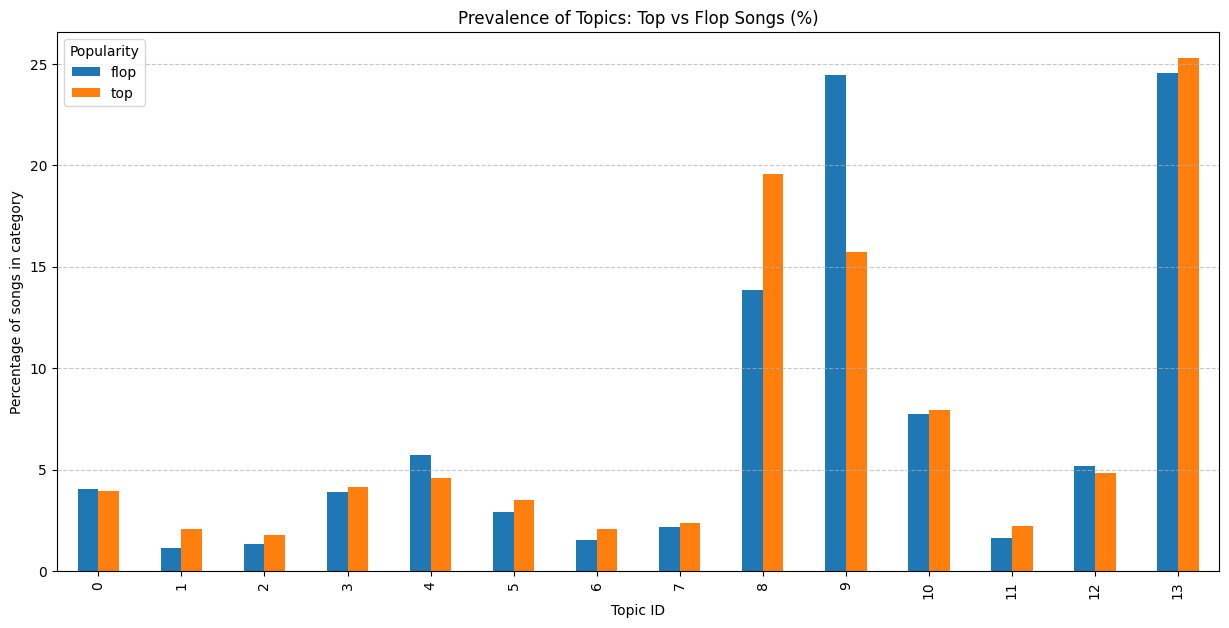


Chi-square test of independence between Topic and Popularity:
  - Chi2: 1543.08
  - P-value: 0.0000e+00
  => The distribution of topics is significantly different between Top and Flop songs.


In [ ]:
# Comparative topic distribution: Top vs Flop
plt.figure(figsize=(14, 6))

# Computing percentages by group for a fair comparison
topic_counts = df_analysis.groupby(['popularity', 'Topic']).size().unstack(fill_value=0)
topic_pcts = topic_counts.div(topic_counts.sum(axis=1), axis=0) * 100

topic_pcts.T.plot(kind='bar', figsize=(15, 7))
plt.title("Prevalence of Topics: Top vs Flop Songs (%)")
plt.xlabel("Topic ID")
plt.ylabel("Percentage of songs in category")
plt.legend(title="Popularity")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Statistical check (Chi-square) if interested in significance
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(topic_counts)
print(f"\nChi-square test of independence between Topic and Popularity:")
print(f"  - Chi2: {chi2:.2f}")
print(f"  - P-value: {p:.4e}")
if p < 0.05:
    print("  => The distribution of topics is significantly different between Top and Flop songs.")
else:
    print("  => No significant difference in topic distribution found.")

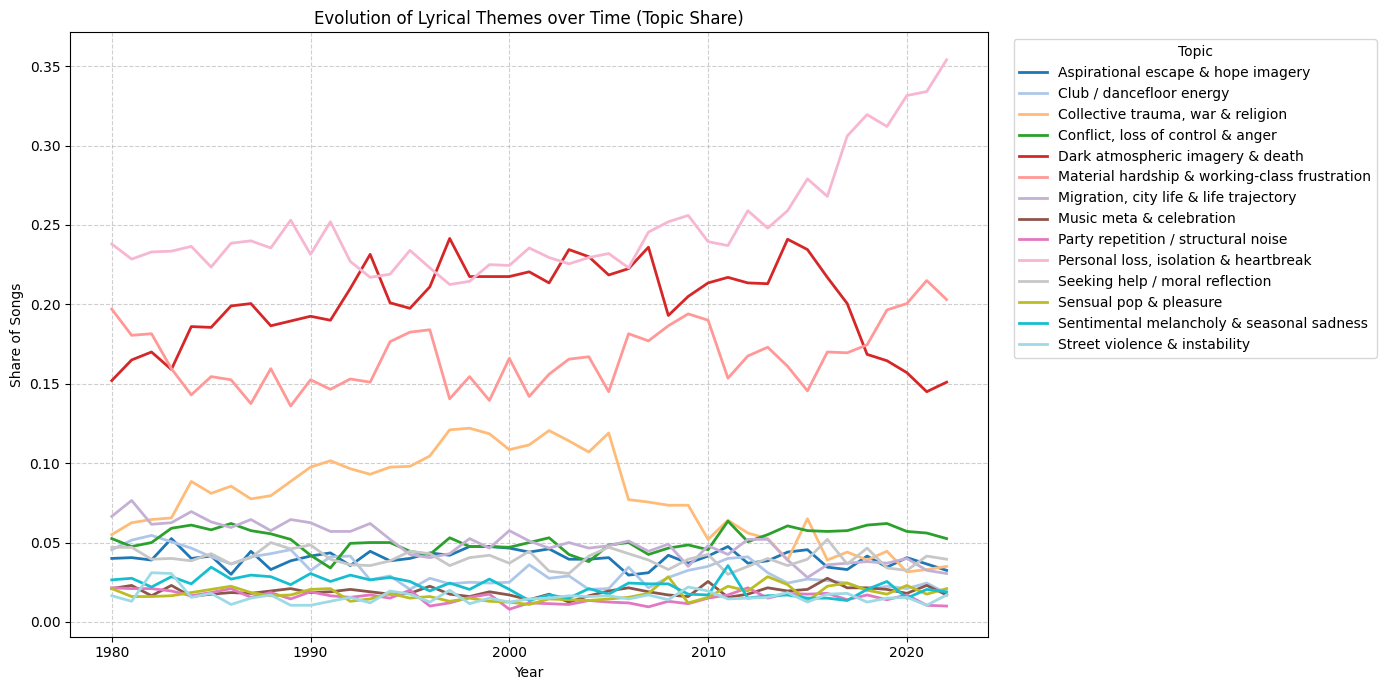

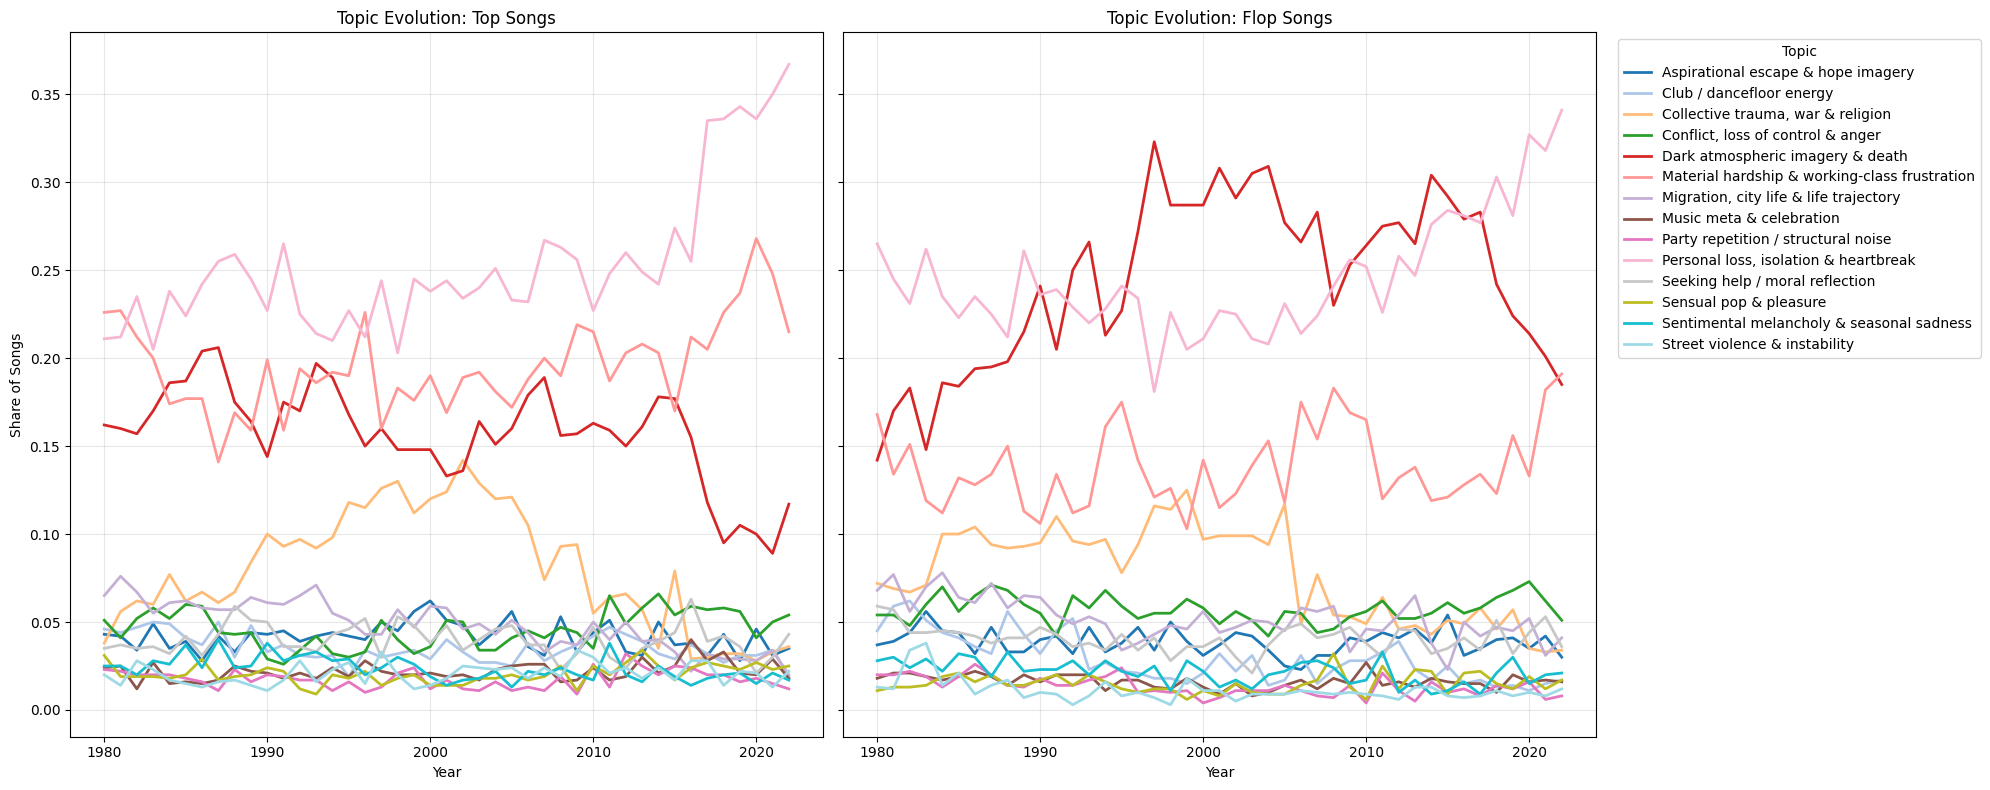

In [21]:
topic_labels = {
    0: "Seeking help / moral reflection",
    1: "Street violence & instability",
    2: "Party repetition / structural noise",
    3: "Aspirational escape & hope imagery",
    4: "Conflict, loss of control & anger",
    5: "Club / dancefloor energy",
    6: "Sensual pop & pleasure",
    7: "Sentimental melancholy & seasonal sadness",
    8: "Material hardship & working-class frustration",
    9: "Dark atmospheric imagery & death",
    10: "Collective trauma, war & religion",
    11: "Music meta & celebration",
    12: "Migration, city life & life trajectory",
    13: "Personal loss, isolation & heartbreak",
}

# Use the DTM and LDA model from previous steps
doc_topic = LDA.transform(dtm)  # shape: (n_docs, n_topics)

# Dominant topic per song
dominant_topic = doc_topic.argmax(axis=1)
dominant_score = doc_topic.max(axis=1)

# Using our combined dataset df_analysis
df_topics = df_analysis.copy()
df_topics["dominant_topic_id"] = dominant_topic
df_topics["dominant_topic_label"] = df_topics["dominant_topic_id"].map(topic_labels)
df_topics["dominant_topic_score"] = dominant_score

# Keep full topic mixture columns
for k in range(LDA.n_components):
    df_topics[f"topic_{k}_prob"] = doc_topic[:, k]

# Time chart logic
year_topic_counts = (
    df_topics.dropna(subset=["year"])
             .groupby(["year", "dominant_topic_label"])
             .size()
             .reset_index(name="count")
)

# Convert to share per year
year_totals = year_topic_counts.groupby("year")["count"].transform("sum")
year_topic_counts["share"] = year_topic_counts["count"] / year_totals

pivot_share = year_topic_counts.pivot(index="year", 
                                      columns="dominant_topic_label", 
                                      values="share").fillna(0).sort_index()

plt.figure(figsize=(14, 7))
# Use 'tab20' colormap to ensure 14 distinct colors
pivot_share.plot(ax=plt.gca(), linewidth=2, colormap='tab20')
plt.title("Evolution of Lyrical Themes over Time (Topic Share)")
plt.xlabel("Year")
plt.ylabel("Share of Songs")
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Evolution by popularity category (Top vs Flop)
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

for i, pop in enumerate(["top", "flop"]):
    subset = df_topics[df_topics["popularity"] == pop]
    counts = subset.groupby(["year", "dominant_topic_label"]).size().reset_index(name="count")
    totals = counts.groupby("year")["count"].transform("sum")
    counts["share"] = counts["count"] / totals
    
    pivot = counts.pivot(index="year", columns="dominant_topic_label", values="share").fillna(0)
    # Use 'tab20' here as well
    pivot.plot(ax=axes[i], linewidth=2, legend=(i==1), colormap='tab20')
    
    axes[i].set_title(f"Topic Evolution: {pop.capitalize()} Songs")
    axes[i].set_xlabel("Year")
    axes[i].grid(True, alpha=0.3)

axes[0].set_ylabel("Share of Songs")
if axes[1].get_legend():
    axes[1].legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [31]:
# --- PREPARATION FOR XGBOOST ---
# 1. Encoding dominant topic (One-Hot Encoding)
# This adds 14 binary columns 'topic_id_0', 'topic_id_1', etc.
df_encoded = pd.get_dummies(df_topics, columns=['dominant_topic_id'], prefix='topic_id')

# 3. Export to Parquet for the XGBoost Notebook
output_path = "data/pop_lyrics_with_topics.parquet"
df_encoded.to_parquet(output_path)

print(f"Dataset for XGBoost created successfully: {output_path}")
print(f"Shape: {df_encoded.shape}")
print(f"Topic features added: { [col for col in df_encoded.columns if 'topic_id_' in col or 'prob' in col] }")

Dataset for XGBoost created successfully: data/pop_lyrics_with_topics.parquet
Shape: (86000, 39)
Topic features added: ['topic_0_prob', 'topic_1_prob', 'topic_2_prob', 'topic_3_prob', 'topic_4_prob', 'topic_5_prob', 'topic_6_prob', 'topic_7_prob', 'topic_8_prob', 'topic_9_prob', 'topic_10_prob', 'topic_11_prob', 'topic_12_prob', 'topic_13_prob', 'topic_id_0', 'topic_id_1', 'topic_id_2', 'topic_id_3', 'topic_id_4', 'topic_id_5', 'topic_id_6', 'topic_id_7', 'topic_id_8', 'topic_id_9', 'topic_id_10', 'topic_id_11', 'topic_id_12', 'topic_id_13']


# Econometrics Analysis - XGBoost
- evaluate the popularuty of a song and the impact of different factors

In [ ]:
# Import of the fully prepared dataset
df_filtered = pd.read_parquet(
    "data/pop_lyrics_with_topics.parquet"
)

df_filtered.info()

In [ ]:
# Topic Label Mapping 
TOPIC_LABELS = {
    0: "Seeking help / moral reflection",
    1: "Street violence & instability",
    2: "Party repetition / structural noise",
    3: "Aspirational escape & hope imagery",
    4: "Conflict, loss of control & anger",
    5: "Club / dancefloor energy",
    6: "Sensual pop & pleasure",
    7: "Sentimental melancholy & seasonal sadness",
    8: "Material hardship & working-class frustration",
    9: "Dark atmospheric imagery & death",
    10: "Collective trauma, war & religion",
    11: "Music meta & celebration",
    12: "Migration, city life & life trajectory",
    13: "Personal loss, isolation & heartbreak",
}

In [ ]:
# Feature Engineering
def prepare_features(df_input):
    df_features = df_input.copy()
    
    # 1. Basic Lyrics Scores
    df_features['lexical_diversity'] = df_features['clean_lyrics'].apply(
        lambda x: len(set(str(x).split())) / len(str(x).split()) if len(str(x).split()) > 0 else 0
    )
    
    # 2. Topic Features
    prob_cols = [c for c in df_input.columns if c.endswith('_prob')]
    id_cols = [c for c in df_input.columns if c.startswith('topic_id_')]
    
    # 3. Sentiment & Emotion Features
    sentiment_cols = ['sentiment_compound', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu']
    emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
    readability_cols = ['flesch_reading_ease', 'flesch_kincaid_grade']
    
    existing_nlp_cols = [c for c in sentiment_cols + emotion_cols + readability_cols if c in df_input.columns]
    
    # 4. Define final feature matrix and target
    feature_cols = prob_cols + id_cols + existing_nlp_cols
    
    # Target: Views (Log transform)
    df_features['target_views'] = np.log1p(df_features['views'])
    
    # Ensure all feature columns are numeric
    X_data = df_features[feature_cols].copy()
    for col in X_data.columns:
        X_data[col] = pd.to_numeric(X_data[col], errors='coerce').fillna(0)
    
    # Mapping readable names for plotting
    readable_feature_names = []
    for col in feature_cols:
        if 'topic_id_' in col:
            idx = int(col.split('_')[-1])
            readable_feature_names.append(f"Primary Topic: {TOPIC_LABELS.get(idx, col)}")
        elif '_prob' in col:
            idx = int(col.split('_')[1])
            readable_feature_names.append(f"Topic Mixture: {TOPIC_LABELS.get(idx, col)}")
        else:
            readable_feature_names.append(col.replace('_', ' ').title())
            
    return X_data, df_features['target_views'], readable_feature_names

# Prepare data
X, y, feature_names = prepare_features(df_filtered)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set feature names on DataFrame to ensure XGBoost uses them
X_train.columns = feature_names
X_test.columns = feature_names

# Training XGBoost
print(f"Training XGBoost Regressor on {len(X_train)} songs...")
model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=50
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# 1. Multi-Type Feature Importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# Gain: Total gain of the scores which the feature contributes to
xgb.plot_importance(model, importance_type='gain', max_num_features=15, ax=ax1, title="Importance by Gain (Most Accurate)")
# Weight: Number of times a feature is used to split the data across all trees
xgb.plot_importance(model, importance_type='weight', max_num_features=15, ax=ax2, title="Importance by Weight (Frequency)")

plt.tight_layout()
plt.show()

# 2. Print Importance Table
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': model.feature_importances_
}).sort_values('Gain', ascending=False)

print("\n" + "="*50)
print("TOP 20 MOST INFLUENTIAL Lyrical Features (Gain)")
print("="*50)
print(importance_df.head(20).to_string(index=False))
print("="*50)

# 3. Permutation Importance
print("\nCalculating Permutation Importance (more robust)...")
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-20:]

plt.figure(figsize=(10, 10))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Mean Decrease in R2 Score")
plt.title("Robust Feature Importance (Permutation)")
plt.tight_layout()
plt.show()